# fifa analysis: improve recruiting
---

## notebook goals
1. advise client on which players need to be replaced
2. advise client on good replacements

## framing
* client: the management of a team
* client's desire: to build the best team and make the most money
   
## data
* Player personal attributes (Nationality, Club, Photo, Age, Value etc.)
* Player performance attributes (Overall, Potential, Aggression, Agility etc.)
* Player preferred position and ratings at all positions.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [118]:
players = pd.read_csv("CompleteDataset_cleaned.csv",index_col='index')
players.head()

/Users/nico/code/pydata-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
index,,,,,,,,,,,,,,,,,,,,,
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,95500000.0,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,105000000.0,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,123000000.0,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,97000000.0,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,61000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
primary = players[['Overall','Potential','Value','Wage','Age']]

#  recruiting a better team
the client would like to replace his worst players for players of equal or better skill who are currently earning less. 

### steps
1. pick 1 team to consult for: Real Madrid CF
2. pick the worst player and find all other players that are as good as him,have as good value as him, and are cheaper
3. add a filter by position (this should significantly reduce the available options)
4. scale the solution to all other members of the team

## step 1: picking a team
I've decided to first consult for **Real Madrid**. This is one of the most valuable teams, with one of the biggest budgets and most highly paid players. It should be easy to find players who are just as good but earn significantly less. The solution I come up with should be scalable to all teams eventually.

## step 2: find replacements for the worst player

In [120]:
madrid = players[players["Club"] == "Real Madrid CF"]
worst = madrid.loc[madrid["Overall"].argmin()]
# replacements = players[
#     (players['Overall'] >= worst['Overall']) &
#     (players["Value"] >= worst["Value"]) &
#     (players["Wage"]  < worst["Wage"]) &
#     (players["Club"] != "Real Madrid CF")
# ]

#there are 5371 players who are equal or better than madrid's worst player
#we need to come up with a more strict filter that is more realistic
#let's find players whose wage would be doubled if they joined madrid,
#and have 2000% more value


value_replacements = players[
    (players['Overall'] >= worst['Overall']) &
    (players["Value"] >= 20 * worst["Value"]) &
    (players["Wage"]  < 0.5 * worst["Wage"]) &
    (players["Club"] != "Real Madrid CF")
]

#we have narrowed it down to 7 players
#but maybe I have faulty reasoning:perhaps value is relative to the other players on your team?
#madrid doesn't need more valuable players because it has plenty of those:I will optimize for skill instead 

skill_replacements = players[
    (players['Overall'] >= 1.2 * worst['Overall']) &
    (players["Value"] >= worst["Value"]) &
    (players["Wage"]  < 0.5 * worst["Wage"]) &
    (players["Club"] != "Real Madrid CF")
]

#it looks like the value_replacements and the skill_replacements are a similar set of people
#let's do a comparison to confirm that
overlap = set(value_replacements.index).intersection(set(skill_replacements.index))

skill_replacements[skill_replacements.index.isin(overlap)]

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
index,,,,,,,,,,,,,,,,,,,,,
252,Taison,29,https://cdn.sofifa.org/48/18/players/188803.png,Brazil,https://cdn.sofifa.org/flags/54.png,82,82,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,21500000.0,...,63.0,55.0,76.0,64.0,81.0,81.0,77.0,82.0,66.0,77.0
253,Marlos,29,https://cdn.sofifa.org/48/18/players/187754.png,Brazil,https://cdn.sofifa.org/flags/54.png,82,82,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,21500000.0,...,64.0,56.0,77.0,65.0,81.0,81.0,76.0,82.0,68.0,76.0
406,Fred,24,https://cdn.sofifa.org/48/18/players/209297.png,Brazil,https://cdn.sofifa.org/flags/54.png,80,85,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,19500000.0,...,76.0,70.0,79.0,76.0,77.0,79.0,72.0,78.0,77.0,72.0
412,T. Stepanenko,27,https://cdn.sofifa.org/48/18/players/206413.png,Ukraine,https://cdn.sofifa.org/flags/49.png,80,81,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,14000000.0,...,76.0,78.0,75.0,79.0,69.0,70.0,68.0,68.0,76.0,68.0
434,Y. Rakitskyi,27,https://cdn.sofifa.org/48/18/players/195861.png,Ukraine,https://cdn.sofifa.org/flags/49.png,80,82,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,14500000.0,...,78.0,79.0,77.0,80.0,71.0,72.0,69.0,70.0,78.0,69.0
559,Bernard,24,https://cdn.sofifa.org/48/18/players/205525.png,Brazil,https://cdn.sofifa.org/flags/54.png,79,84,Shakhtar Donetsk,https://cdn.sofifa.org/24/18/teams/101059.png,17000000.0,...,59.0,47.0,72.0,57.0,78.0,79.0,73.0,80.0,62.0,73.0
761,K. Fortounis,24,https://cdn.sofifa.org/48/18/players/203980.png,Greece,https://cdn.sofifa.org/flags/22.png,78,82,Olympiakos CFP,https://cdn.sofifa.org/24/18/teams/280.png,13500000.0,...,56.0,50.0,72.0,58.0,76.0,76.0,73.0,76.0,60.0,73.0


## step 3: improve recommendation based on position
Our recommendation can be much better if it is based on position aptitude.

the data provides 2 things that we can use for this:
1. a column that holds a string of preferred positions (as acronyms)
2. a column for each position, with an integer rating for each

### substeps
1. turn the string of preferred positions into a list
2. find out if this list corresponds with the positions for which this player is most skilled
    * is this true for the worst player? 
    * is this true for all players generally?
3. incorporate position skill into replacement filter
    * We don't really care about preferred positions given that we are replacing this player. That said, we're looking into it anyways to see if any insights might appear .

In [121]:
# turn the string of preferred positions into a list
players["Preferred Positions"] = players["Preferred Positions"].apply(lambda x: x.split())

# does this list correspond to most skill positions for the worst player?
# it turns out the worst player does not have ratings from his positions

In [122]:
# let's try this for all players
# get a list of all position columns
players.columns

position_list = ['CAM', 'CB', 'CDM', 'CF', 'CM', 'LAM', 'LB', 'LCB',
           'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 
           'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 
            'RS', 'RW', 'RWB', 'ST']

positions = players[position_list]

# a player may be equally good at several positions. make a list of all best positions
players['best_position_rating'] = positions.max(axis=1)

# we want to include positions which are 1 points away from the best position, to account for error
# furthermore,we are going to use this list to compare it to preferred positions,
# to see if we can use preferred positions as a predictor for best positions
# TODO: create a model to see,within how many points, how strong of a predictor preferred positions are

def bestPositions(row):
    return [name for name in position_list if row[name] >= row['best_position_rating'] - 2]

players['best_positions'] = players.apply(bestPositions, axis=1)

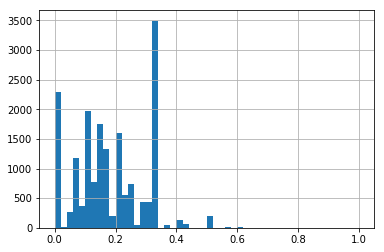

In [123]:
# is preferred position a good indicator for best position?
# TODO: you can modify this to also include information of which that is bigger in the return output
# you could also create a correlation matrix,but this has many more steps
def preferredVersusBest(row):
    preferred = set(row['Preferred Positions'])
    best = set(row['best_positions'])
    overlap = preferred.intersection(best)
    bigger_set = max(len(preferred),len(best))
    return len(overlap)/bigger_set

# it doesn't look like there is a very strong correlation between preferred and best
# so in my recommendation I will look at best positions,not preferred positions
players.apply(preferredVersusBest, axis=1).hist(bins=50)

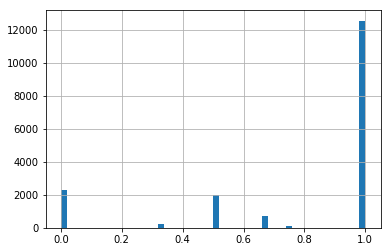

In [124]:
# new idea
# if I can demonstrate that a player's preferred positions are amongst his best positions,
# then we can indeed use preferred positions to make replacement recommendations.
# it is too rigorous to require that there be a one-to-one mapping between preferred and best positions.
# to calculate this,I am simply going to see what percentage of preferred positions are amongst best positions
def preferredInBest(row):
    preferred = set(row['Preferred Positions'])
    best = set(row['best_positions'])
    overlap = preferred.intersection(best)
    return len(overlap)/len(preferred)

# it doesn't look like there is a very strong correlation between preferred and best
# so in my recommendation I will look at best positions,not preferred positions
players['preferred_in_best'] = players.apply(preferredInBest, axis=1)
players['preferred_in_best'].hist(bins=50)

# this is more promising. note that I counted any position that is within 2 of the best

In [125]:
# let's find out how many of these are due to bad data
players[players['preferred_in_best'] == 0][['Preferred Positions','best_positions']]

# it looks like most of these are goalkeepers. let's assume that if you're a goalkeeper,that is your best position

,Preferred Positions,best_positions
index,,
4,[GK],[]
6,[GK],[]
12,[GK],[]
18,[GK],[]
20,[GK],[]
29,[GK],[]
43,[GK],[]
45,"[LM, CM]","[CAM, LAM, RAM]"
68,[GK],[]


In [127]:
# create a filter to find all people whose preferred position is inserted
def findPosition(preferred,position):
    if position in preferred:
        return True
    else:
        return False

# for all goalkeepers who do not have a best position,insert GK as their best position
def fillGoalkeepers(row):
    if 'GK' in row['Preferred Positions'] and row['preferred_in_best'] == 0:
        return ['GK']
    else:
        return row['best_positions']

players['best_positions'] = players.apply(fillGoalkeepers, axis=1)

# now rerun the preferred in best check
# players['preferred_in_best'] = players.apply(preferredInBest, axis=1)
# players['preferred_in_best'].hist(bins=50)
# players['best_positions']
players['best_positions']

In [128]:
# players[players['Preferred Positions'] is None]
players.describe()

count     0
unique    0
dtype: int64

# client recommendation
indeed,we have narrowed our list to 7 recommendations.
* these 7 players are at least 20% better that our player.
* they also provide at least 2000% more value.
* they are also earning at most 50% of our worst players salary.

## next steps
1. make player recommendations based on position
2. rewrite this code so that it can be scaled to any player and parameterized 
3. make recommendations based on age,where younger players are more valuable
4. make recommendations based on geography, where closer players are more valuable
5. take into account a player's  willingness to change teams

---
# 3 - Predicting performance
We know that Overall is the overall skill of a player.
The question is whether we can predict the Overall skill by looking at the other skills.

assumptions:
* the client prefers to measure a few skills rather than the entire suite.
* while all of these skill metrics are subjective, it is more objective to measure a player on specific skills,rather than to come up with an overall skill rating just from observation.

ideal deliverables:
* the client would like to know which of his players he should get rid of.
* the client would like to know which skills he should focus his players on to optimize overall skill.
* the client would like to know who are the most undervalued players, so he can recruit them.

In [ ]:
#remove the pluses and minuses from these numbers
import re

skill_columns = ['Acceleration',
       'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
       'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
       'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
       'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys']

def stripValue(value):
    if isinstance(value, str):
        return int(re.findall('\d+',value)[0])
    else:
        return None

#is this the right way to do this ?why am I getting a warning?
for column in skill_columns:
    player_stats[column] = player_stats[column].apply(stripValue)

In [ ]:
player_stats.head()

In [ ]:
player_stats.dropna(inplace=True)

In [ ]:
for column in skill_columns:
    sns.distplot(player_stats[column],bins=50)

In [ ]:
#I want to analyze the connections between these different features, 
#however this particular notebook doesn't have the tools to do so .
#it is tempting to go ahead and find those tools,but I should stay on track 

#I want to know the correlation between each of these skills and overall skill
#I want to do a principal component analysis to reduce these skills to the single most important ones
#I want to see if a particular skill is more important than another
#I want to discover what is the lowest mix of skills that optimizes for the value of the player
#I want to see which minimal features do a good job of predicting overall skill



## Simple Linear Regression: 2 independent variables

the rest of this notebook is linear regression
I need to pick the top 3 skills that are most highly correlated with overall skill and value
then I need to do a linear regression and assess how strong that is right paren

In [ ]:
#correlation
correlation_matrix = player_stats.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(correlation_matrix,annot=False,cmap='coolwarm', linewidths=.5, ax=ax)
#
#the strongest skill correlation 2 Overall is Reactions
#I don't think this is a skill.
#first I'll try to make a linear regression between the top 3 skills and overall
#then I will try to take all skills and see if that gives me a better model

In [ ]:
#skills with the highest correlation
correlation_overall = correlation_matrix['Overall'].sort_values(ascending=False)

correlation_overall.head(15)
#I'm only going to use reactions and composure in this first model.
#the other values are not skills,and of the other skills are too lowly correlated

In [ ]:
#define the training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = player_stats['Overall']
X = player_stats[['Reactions','Composure']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients

In [ ]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

evaluate  model performance by calculating the residual sum of squares and the explained variance score (R^2).

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

# first conclusion
the only highly correlated skill to overall is reactions.I created a linear regression model
that can predict overall fairly well.I'm not very excited about this though.
there is more to the story.I wouldn't tell management to look for players with good reactions
in order to build a good team.

I am going to build another model,and I will leave out reactions.let's see how good it can be.
it will only take into account real,more measurable skills.

## Simple Linear Regression: low correlation features
in this model, I am only going to use features with low correlation to see how good of a predictor I can create.

In [ ]:
#skills with the highest correlation
correlation_overall = correlation_matrix['Overall'].sort_values(ascending=False)

#exclude features with the highest correlations,those above 0.53
low_correlated_skills  = correlation_overall[correlation_overall < 0.53].index.values
low_correlated_skills

In [ ]:
#define the training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = player_stats['Overall']
X = player_stats[low_correlated_skills]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients

In [ ]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

evaluate  model performance by calculating the residual sum of squares and the explained variance score (R^2).

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

# second conclusion
in this second model I excluded the most highly correlated features,those being reactions and composure.
I wanted to see if I could create a predictive model using very lowly correlated features.my assumption was that the higher the correlation,the more likely that feature predicts the y value.perhaps this is true,and there is another truth in here.the other truth is that a large group of lowly correlated features can also give a good predictive model.

now my goal is to create the most predictive model.I will do this by including the highly correlated features as well as the lowly correlated features into my model.

## Simple Linear Regression: all features


In [ ]:
#define the training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = player_stats['Overall']
X = player_stats[skill_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient',ascending=False)

even though composure is more highly correlated then ball control, here ball control has a higher coefficient then  composure. I must have a wrong assumption about how this math works. something I can try to do is to see the correlation between coefficients and correlation values.

In [ ]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

evaluate  model performance by calculating the residual sum of squares and the explained variance score (R^2).

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

## third conclusion
it appears that the best model is when you use the most features.

* highly correlated features RMSE: 3.31230582722
* only low correlated future RMSE: 3.25479269275
* all features RMSE: 2.62305737694

## critique

1. your initial goal was to study a player's performance
    * you didn't formulate clear questions: 
        * which metric is the best representation for performance? _overall_
        * which smaller metric is the best predictor for performance?
        * which set of 5 smaller metrics are the best predictors for performance?
    * you didn't make recommendations to your client:
        * should players focus on their best skills or the worst skills to get better performance?
        * which players have the best wage to value ratio?
        * which players have the best wage to overall ratio?
        * who are the weakest players on any given team?
        
2. your secondary goal was to study a team's performance
    * you don't have data on teams winning
    * you didn't study the connection between individual players and team skill
        * what is the best player mix for a good team?
        * what is the best way to predict a team skill based on individual player features?

3. your third goal was to make financial recommendations 
    * which teams have the best wage to value ratios?
    * which teams have the best wage to overall ratios?
    
---

1. each section needs an explicit goal, with steps laid out
2. each section needs an explicit conclusion, that cites the values discovered
3. whenever you learn something from a calculation, you should write that down
4. make your variable names more clear